# Construction of eulerian comparison dataframe
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

#### Imports

In [1]:
import sys
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from Drifters_filters import *


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'
path_fields = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/fields_data'

path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/drifters_scenes'
#path_save_plot = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-06-27_Generate_eulerian_points_dataframe_L3'

## Data and utils

#### field data

In [2]:
# L3 field data
ds_swot = xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc'))

#ds_swot  = add_Tgrid_velocities(ds_swot,  replace=True)
ds_swot

<xarray.Dataset>
Dimensions:    (time: 90, y: 399, x: 69)
Coordinates:
  * time       (time) datetime64[ns] 2023-03-30T00:12:09 ... 2023-07-09T08:16:31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    ssh        (time, y, x) float32 ...
    u_geos     (time, y, x) float32 ...
    v_geos     (time, y, x) float32 ...
    u_var      (time, y, x) float32 ...
    v_var      (time, y, x) float32 ...
Attributes:
    DATAPRODUCT:   L3SWOT_20240626
    gridtype_adt:  T grid : (latitude, longitude)
    gridtype_uv:   U/V grid

## Closest interpolation

In [9]:

def interp_closest_velocity_field_L3(ds, u: str, v: str, time_vec, lat_vec, lon_vec):

    #find the closest x,y coords of the interpolation points 
    x_vec = np.empty_like(lon_vec)
    y_vec = np.empty_like(lat_vec)

    for i, (lon, lat) in enumerate(zip(lon_vec, lat_vec)):
        abslat = np.abs(ds.latitude-lat)
        abslon = np.abs(ds.longitude-lon)
        c = np.maximum(abslon, abslat)

        min_idx = np.where(c == np.min(c))
        y_vec[i], x_vec[i] = min_idx[0][0], min_idx[1][0]

    #create indexers DataArrays 
    x_idx = xr.DataArray(x_vec)
    y_idx = xr.DataArray(y_vec)
    time_idx = xr.DataArray(time_vec)

    #xarray interpolate
    interped = ds.interp(x=x_idx, y=y_idx, time=time_idx)

    return interped[u].values, interped[v].values

#### test : plot geostrophic currents interpolated

In [10]:
lat = [40, 40.2, 40.4, 40.6]

lon = [4.9]*len(lat)
time = np.array(['2023-04-03T23:25:18.000000000']*len(lat), dtype='datetime64[ns]' )
                
u, v = interp_closest_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=time, lat_vec=lat, lon_vec=lon)

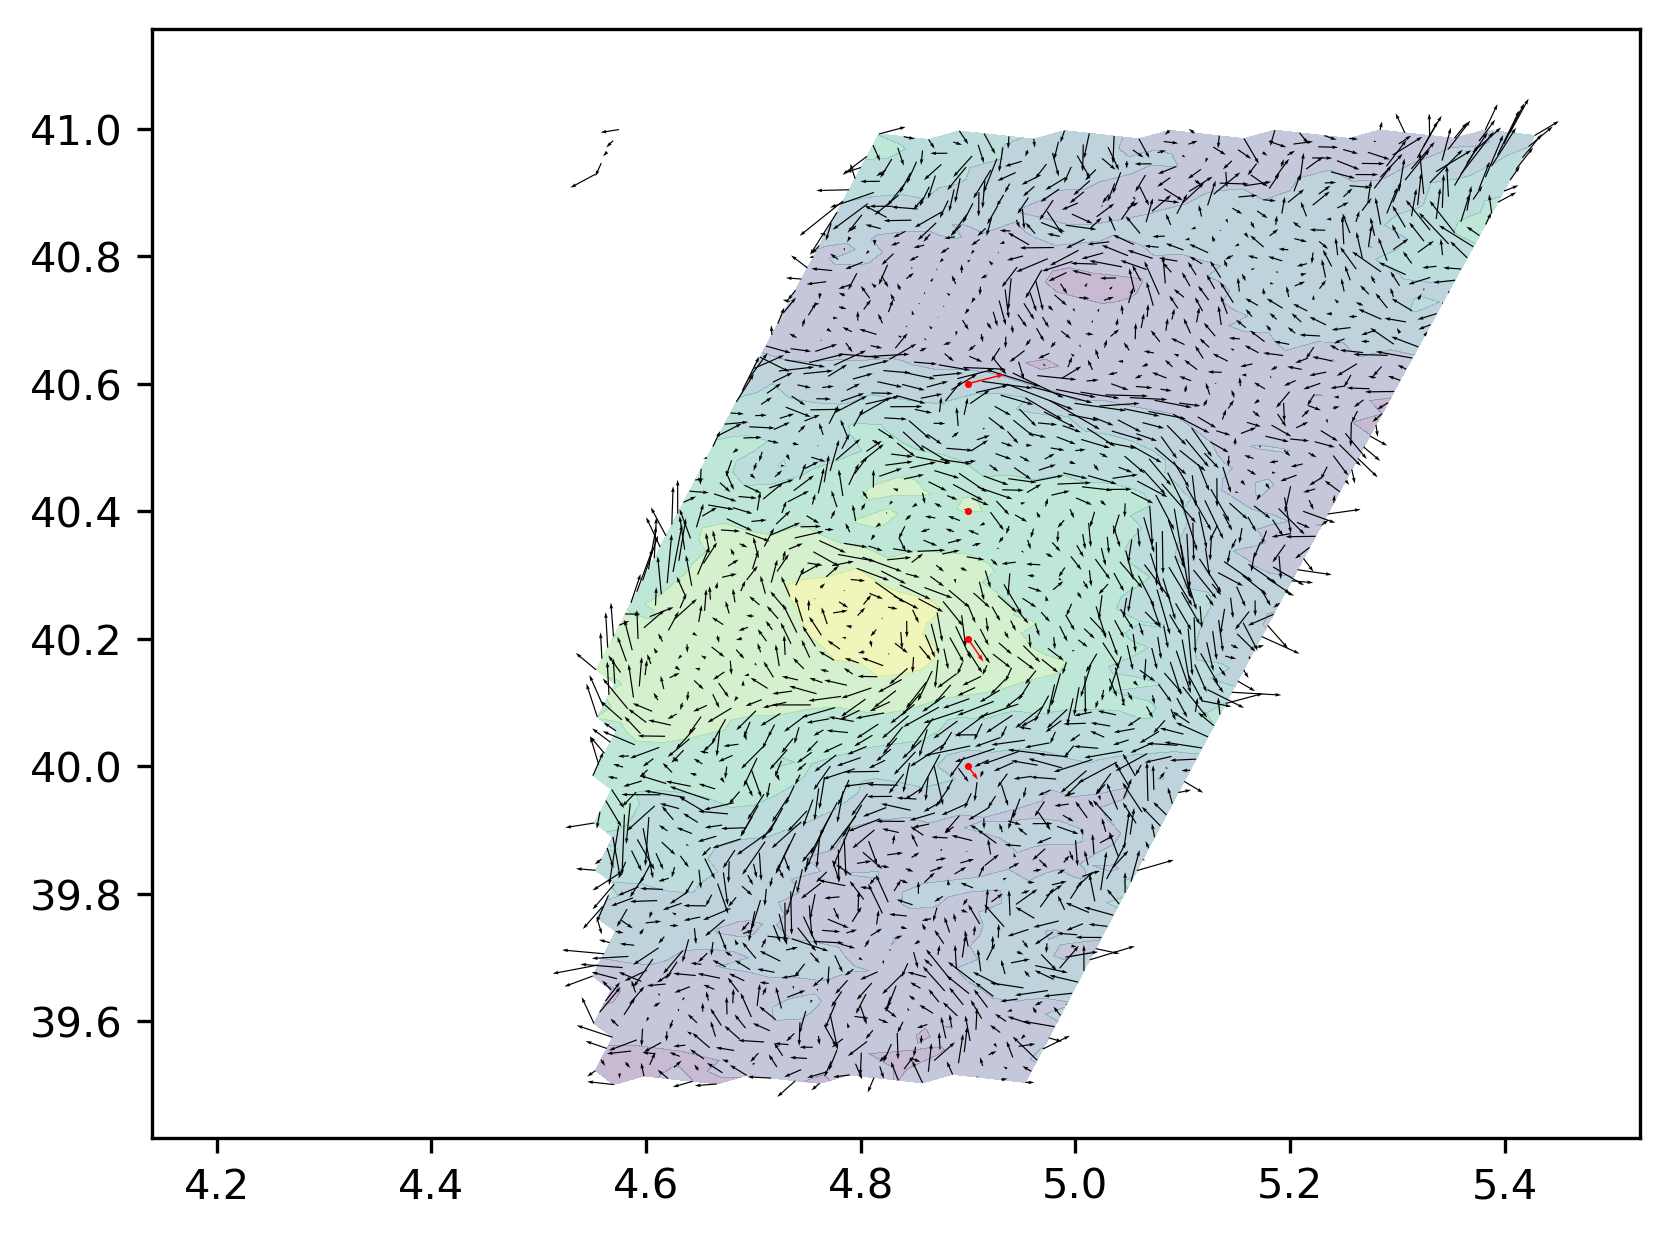

In [11]:
matplotlib.rcParams['figure.dpi'] = 300


ds = ds_swot.isel(time=4)

bbox= [4.55, 5.5, 39.5, 41]
ds = restrain_domain(ds, *bbox)

plt.contourf(ds.longitude, ds.latitude, ds.ssh, cmap='viridis', alpha=0.3)
plt.quiver(ds.longitude, ds.latitude, ds.u_geos, ds.v_geos, scale=20, width=0.0008)

plt.scatter(lon, lat, c='r', s=0.5)
plt.quiver(lon, lat, u, v, scale=20, width=0.001, color='red')

## Linear interpolation

In [19]:


def interp_linear_velocity_field_L3(field, u: str, v: str, time_vec, lat_vec, lon_vec, dlat=0.022, dlon=0.03):
    """
    Interpolate linearly velocity field components from a dataset, with neighborhood points (dlat, dlon).
    If less than 4 points are in the neighborhood, np.nan values are return. 

    Parameters:
    -----------
    ds : xarray.Dataset
        The input dataset containing the velocity field components and the 
        coordinates `time`, `latitude` and `longitude`.
    u : str
        The name of the variable representing the u-component of the velocity 
        field in the dataset.
    v : str
        The name of the variable representing the v-component of the velocity 
        field in the dataset.
        
    time_vec : array-like
        A vector of time points at which to interpolate the velocity fields.
    lat_vec : array-like
        A vector of latitude points at which to interpolate the velocity fields.
    lon_vec : array-like
        A vector of longitude points at which to interpolate the velocity fields.

    dlat, dlon : radius of points in the neighborhood taken in the interpolation

    Returns:
    --------
    np.ndarray
        The interpolated values of the u-component of the velocity field at the 
        specified times, latitudes, and longitudes. 
    np.ndarray
        The interpolated values of the v-component of the velocity field at the 
        specified times, latitudes, and longitudes.
    """
    u_interp = np.empty(shape=time_vec.shape)
    v_interp = np.empty(shape=time_vec.shape)

    for i, (lon, lat, time) in enumerate(zip(lon_vec, lat_vec, time_vec)):

        ds = field.interp(time=time).copy(deep=True)
        neighboord_points = np.logical_and(np.abs(ds.latitude - lat) < dlat, np.abs(ds.longitude - lon) < dlon) 
        ds = ds.where(neighboord_points, drop=True)
        
        # get the number of point selected
        n_points = np.sum(~np.isnan(ds[u].values.flatten()))
        print(n_points)
        if n_points < 4:
            u_interp[i], v_interp[i] = np.nan, np.nan
        else:
            u_interp[i] = scipy.interpolate.griddata((ds.latitude.values.flatten(), ds.longitude.values.flatten()), ds[u].values.flatten(), (lat, lon))
            v_interp[i] = scipy.interpolate.griddata((ds.latitude.values.flatten(), ds.longitude.values.flatten()), ds[v].values.flatten(), (lat, lon))
    
    return u_interp, v_interp

In [20]:
lat = [40, 40.2, 40.4, 40.6]

lon = [4.9]*len(lat)
time = np.array(['2023-04-03T23:25:18.000000000']*len(lat), dtype='datetime64[ns]' )
                
u, v = interp_linear_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=time, lat_vec=lat, lon_vec=lon)

6
7
7
5


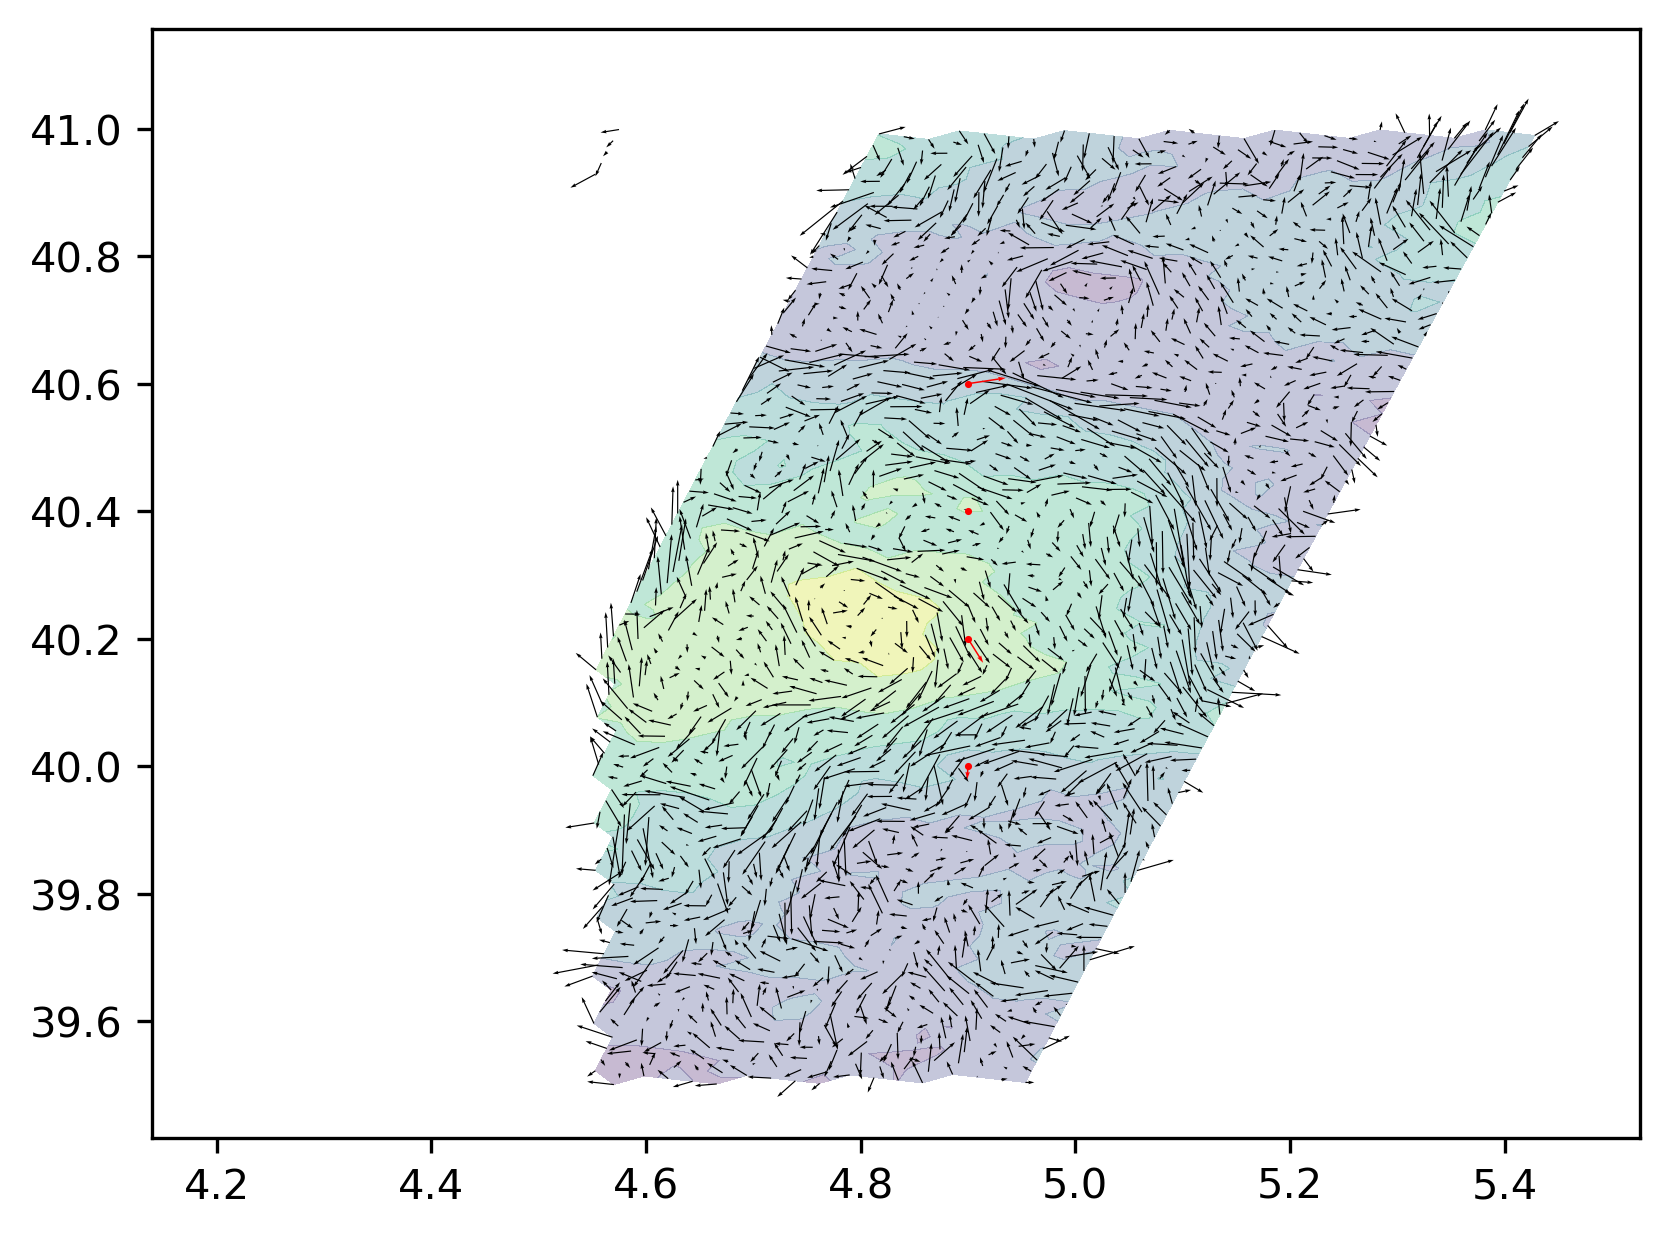

In [21]:
matplotlib.rcParams['figure.dpi'] = 300


ds = ds_swot.isel(time=4)

bbox= [4.55, 5.5, 39.5, 41]
ds = restrain_domain(ds, *bbox)

plt.contourf(ds.longitude, ds.latitude, ds.ssh, cmap='viridis', alpha=0.3)
plt.quiver(ds.longitude, ds.latitude, ds.u_geos, ds.v_geos, scale=20, width=0.0008)

plt.scatter(lon, lat, c='r', s=0.5)
plt.quiver(lon, lat, u, v, scale=20, width=0.001, color='red')

In [4]:
u, v = interp_linear_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=np.array(['2023-04-03T23:25:18.000000000']), lat_vec=[40], lon_vec=[5.4])

In [5]:
u

array([nan])